In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [26]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn models for Regression
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    VotingRegressor,
)
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_squared_log_error,
)
from sklearn.model_selection import (
    KFold,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Other machine learning libraries
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Preprocessing and pipelines
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [5]:
#Importing dataset
train = pd.read_csv('/kaggle/input/playground-series-s5e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e2/test.csv')

In [6]:
styled_df = train.head().style.set_properties(**{"background-color": "#f9f9f9", "color": "#333333", "border": "1px solid #ccc", "font-weight": "normal"}).set_table_styles([{"selector": "th", "props": [("background-color", "#1976d2"), ("color", "white"), ("font-weight", "bold")]}]).format(precision=2)
styled_df

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.00,Yes,No,Tote,Black,11.61,112.16
1,1,Jansport,Canvas,Small,10.00,Yes,Yes,Messenger,Green,27.08,68.88
2,2,Under Armour,Leather,Small,2.00,Yes,No,Messenger,Red,16.64,39.17
3,3,Nike,Nylon,Small,8.00,Yes,No,Messenger,Green,12.94,80.61
4,4,Adidas,Canvas,Medium,1.00,Yes,Yes,Messenger,Green,17.75,86.02


In [12]:
styled_df1 = train.describe().style.set_properties(**{"background-color": "#f9f9f9", "color": "#333333", "border": "1px solid #ccc", "font-weight": "normal"}).set_table_styles([{"selector": "th", "props": [("background-color", "#1976d2"), ("color", "white"), ("font-weight", "bold")]}]).format(precision=2)
styled_df1

,id,Compartments,Weight Capacity (kg),Price
count,300000.00,300000.00,299862.00,300000.00
mean,149999.50,5.44,18.03,81.41
std,86602.68,2.89,6.97,39.04
min,0.00,1.00,5.00,15.00
25%,74999.75,3.00,12.10,47.38
50%,149999.50,5.00,18.07,80.96
75%,224999.25,8.00,24.00,115.02
max,299999.00,10.00,30.00,150.00


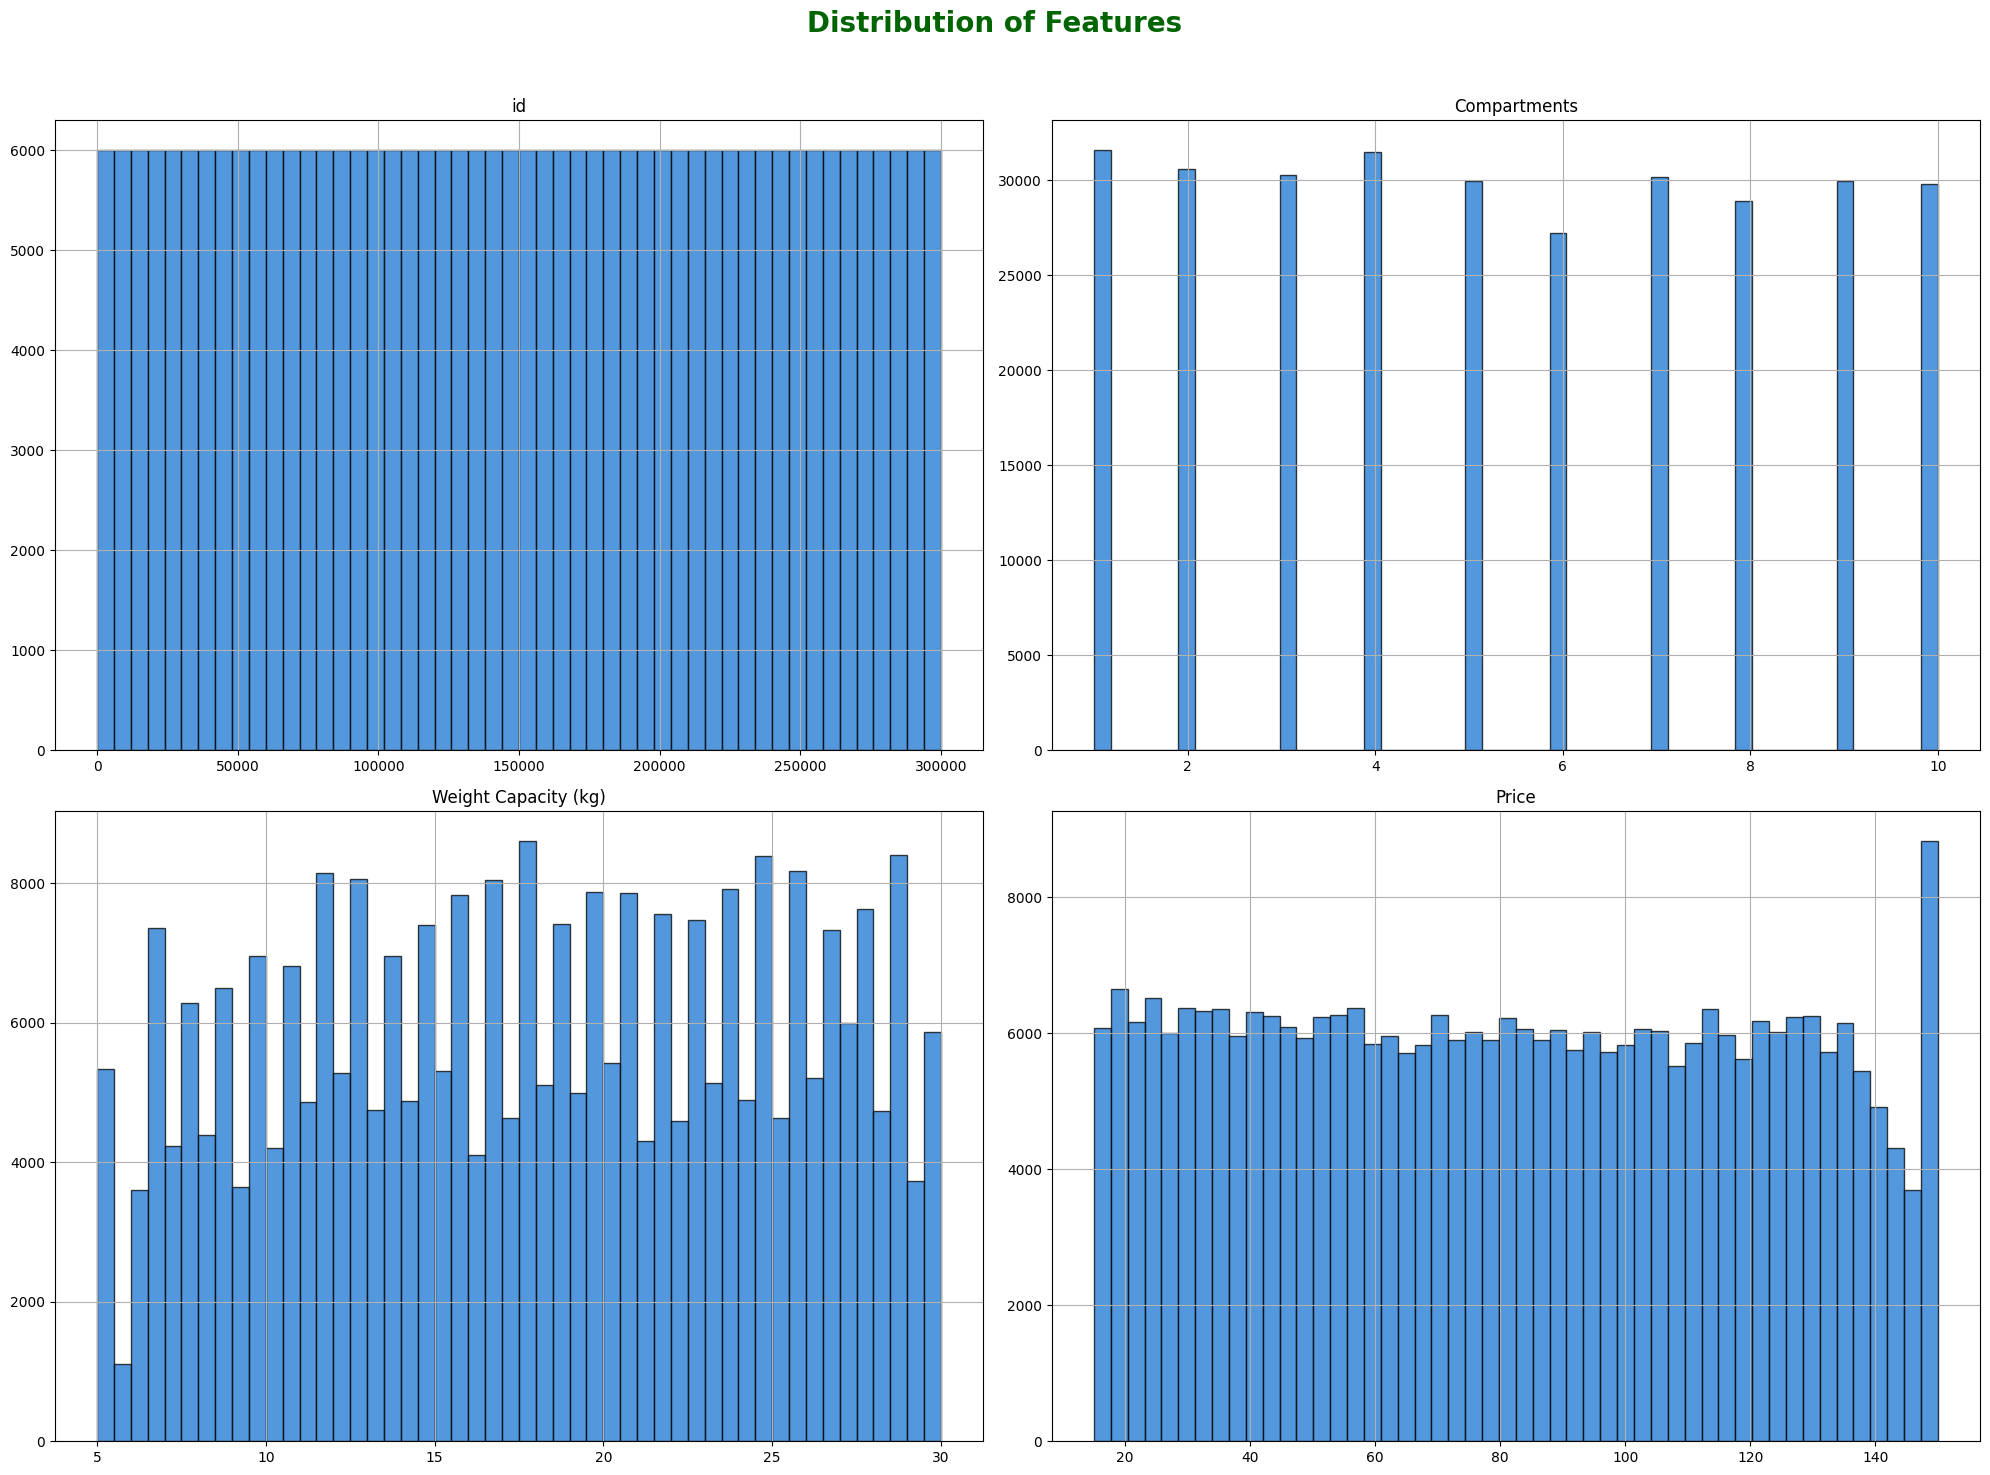

In [10]:
train.hist(
    bins=50, 
    figsize=(20, 15), 
    color='#1976d2', 
    edgecolor='black',
    alpha=0.75
)

# Add global title and adjust layout
plt.suptitle("Distribution of Features", fontsize=20, fontweight='bold', color='darkgreen')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [11]:
#Checking for the missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


In [38]:
# Separate numerical and categorical columns
num_col = [column for column in train.columns if train[column].dtype != 'object' and column not in ['id', 'price']]
cat_col = [column for column in train.columns if train[column].dtype == 'object']

# Print results
print(f"Numerical columns include the following:\n{num_col}")
print(f"Categorical columns include the following:\n{cat_col}")


Numerical columns include the following:
['Compartments', 'Weight Capacity (kg)', 'Price']
Categorical columns include the following:
['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']


In [39]:
# Define imputers
imputer_1 = SimpleImputer(strategy="mean") 
imputer_2 = SimpleImputer(strategy="most_frequent")

# Define scaler and encoder
scaler = StandardScaler()
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")

# Numerical pipeline
numerical_pipeline = Pipeline([
    ('imputer', imputer_1),
    ('scaler', scaler)
])

# Categorical pipeline
categorical_pipeline = Pipeline([
    ('imputer', imputer_2),
    ('one_hot_encoder', one_hot_encoder)
])

In [40]:
# Combine pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num_pipeline', numerical_pipeline, num_col),
    ('cat_pipeline', categorical_pipeline, cat_col) 
])



In [41]:
# Fit and transform the dataset
train_transformed = preprocessor.fit_transform(train)
train_transformed_df = pd.DataFrame(train_transformed)

train_transformed_df.head()


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.538408,-0.921464,0.787608,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.576198,1.299089,-0.320973,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-1.191240,-0.199020,-1.081934,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.884338,-0.731164,-0.020574,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.537170,-0.040293,0.118138,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [51]:
X_train, X_test, y_train, y_test = train_test_split(train_transformed_df, train['Price'], test_size=0.2, random_state=42)

In [52]:
models = {
    "AdaBoost": AdaBoostRegressor(),
    "Bagging": BaggingRegressor(),
    "RandomForest": RandomForestRegressor()
}

In [53]:
model_results = {}

# Loop through the models, train, predict, and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_results[name] = {
        'MSE': mse,
        'R-squared': r2
    }

# Display model performance
for name, metrics in model_results.items():
    print(f"Model: {name}")
    print(f"Mean Squared Error: {metrics['MSE']}")
    print(f"R-squared: {metrics['R-squared']}")
    print("-" * 40)

Model: AdaBoost
Mean Squared Error: 24.447370437191598
R-squared: 0.983880315622356
----------------------------------------
Model: Bagging
Mean Squared Error: 2.2287448792166847e-07
R-squared: 0.9999999998530449
----------------------------------------
Model: RandomForest
Mean Squared Error: 1.4034153557582124e-07
R-squared: 0.999999999907464
----------------------------------------
